In [2]:
# Note: you need to be using OpenAI Python v0.27.0 for the code below to work
import openai
import pandas as pd
import re
from datetime import datetime
import time
import dotenv
config = dotenv.dotenv_values(".env")

openai.api_key = config['OPENAI_API_KEY']

Get Data

In [3]:
from glob import glob
from os import makedirs, path
from pathlib import Path
import json

# Directories
input_dir = "data/truera-slack"
output_file = "out/out.json"

# Get array of files
files = glob(path.join(input_dir, "**", "*.json"))

# Data object
data = pd.DataFrame(columns=["ts","text"])

# Merge all files
for file in files:
    loaded_file = json.load(open(file))
    new_df = pd.DataFrame(pd.json_normalize(loaded_file))[["text","ts"]]
    data = data.append(new_df)

data = data[data["text"].str.contains("has joined")==False]

data = data[data["text"].notna()].reset_index(drop=True)

data

,ts,text
0,1676048028.018639,<@U02LE456XA4> <@U01T3RDQXCN> <@UU20CJJ5U> I’m...
1,1676048055.541539,offline or over google meets is fine if easier
2,1676048398.689969,There is no need to delay. We have a method of...
3,1676048412.180649,"OK, thanks!"
4,1676048454.120839,"in our 1:1, it would be good to get educated o..."
...,...,...
11035,1677228101.061069,I will put it on the agenda.
11036,1676073633.750129,Why do we use a different configuration provid...
11037,1676377010.936829,<@U035T8VRCTG>
11038,1676067899.669649,<@U03PDMMMDL7> - Adding Daniel to this convers...


In [21]:
data.iloc[912]["text"]

"<@U03E8S9JE5V> <@U02BMN3Q3AM> fyi we've to create a doc about the segregation of duties and access control about the environment, this would come up during the audit, I know the team has already done work about physical and logical isolation with IAM policy, we need documentation as reference"

Configure bots

In [4]:
def helpful_bot(prompt):
    return openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
            {"role": "system", "content": "You are a helpful assistant that provides concise and relevant background information and context so that outsiders can easily understand."},
            {"role": "user", "content": prompt}
        ]
    )["choices"][0]["message"]["content"]

In [9]:
def unhelpful_bot(prompt):
    return openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
            {"role": "system", "content": "You are an unhelpful, misleading assistant that provides irrelevant information."},
            {"role": "user", "content": prompt}
        ]
    )["choices"][0]["message"]["content"]

In [22]:
helpful_bot("fyi we've to create a doc about the segregation of duties and access control about the environment, this would come up during the audit, I know the team has already done work about physical and logical isolation with IAM policy, we need documentation as reference")

"Segregation of duties (SoD) and access control are critical components of any organization's security measures. SoD refers to the practice of separating key duties among different individuals to prevent a conflict of interest and reduce the risk of errors or fraud. Access control, on the other hand, refers to the policies and procedures used to control who has access to what resources in an organization.\n\nIn terms of the environment, physical and logical isolation can help prevent unauthorized access, but additional measures are often needed to ensure proper SoD and access control. This may involve implementing role-based access control (RBAC) policies, which grant individuals access based on their specific job responsibilities.\n\nDocumentation is essential, as it provides a reference point for auditors and other stakeholders to understand the organization's security practices. The documentation should include details on the specific roles and responsibilities of individuals, as we

In [6]:
helpful_bot("Why do we use a different configuration provider for query service? for all other java services we use cfg4j, but for query service we seem to be using Spring frameowork’s ConfigurationProperties.")

"There are a few reasons for using a different configuration provider for the query service:\n\n1. The query service has some unique configurations that are different from the other Java services. For example, the query service needs to have a configuration that sets the maximum number of results to return, which is not relevant to the other services. Using Spring framework's ConfigurationProperties allows specific configurations to be easily defined and accessed for the query service.\n\n2. Spring framework's ConfigurationProperties are more commonly used for configuration within Spring applications. Since the query service is a Spring Boot application, it makes sense to leverage the built-in configuration capabilities provided by the framework.\n\n3. There may be a preference for Spring framework's ConfigurationProperties due to its syntax and readability, making it easier for developers to read and understand the configurations. Conversely, cfg4j may be preferred in other services f

In [10]:
unhelpful_bot("fyi we've to create a doc about the segregation of duties and access control about the environment, this would come up during the audit, I know the team has already done work about physical and logical isolation with IAM policy, we need documentation as reference")

'Oh, I see. Did you know that the average lifespan of a sloth is 20 years? While that may not be directly related to your project, the information might come in handy someday. As for your request, have you considered using a typewriter to document your findings? They may be a bit outdated, but they can give your documentation a retro feel that could impress your auditors.'

Configure feedback function for relevance

In [33]:
def relevance_function(prompt, response):
    return re.search('[0-9]+', openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    temperature = 0.5,
    messages=[
            {"role": "system", "content": "You are a relevance classifier, providing the relevance to this text: " + prompt + " Provide all responses only as a number from 0 to 9. Never elaborate."},
            {"role": "user", "content": "Rate the relevance of the following piece of text:" + response}
        ]
    )["choices"][0]["message"]["content"]).group()

In [34]:
prompt = "I have a call scheduled for the 23rd now on this. I do not expect it will move the needle on ML adoption but I do hope it will give us\n• some intel on ML adoption in boi in the last year\n• An opportunity to share how NWG MRM team is using TruEra"
response = "Here is some background information and context that might be helpful for outsiders to understand:\n\n- ML adoption refers to the integration of machine learning algorithms and models into an organization's operations and decision-making processes.\n\n- BOI stands for Bank of Ireland, which is a commercial bank that offers a range of financial services to customers in Ireland and the United Kingdom.\n\n- The call scheduled for the 23rd likely refers to a meeting or conference call between the person asking the question and representatives of Bank of Ireland.\n\n- The purpose of the call is to gather intelligence on Bank of Ireland's adoption of machine learning in the past year.\n\n- TruEra is a machine learning platform that helps organizations monitor and optimize the performance of their machine learning models.\n\n- The NWG MRM team is a group within an organization (likely the person's organization) that is using TruEra to support their machine learning efforts.\n\n- By sharing how the NWG MRM team is using TruEra, the person hopes to demonstrate the benefits of the platform and potentially influence Bank of Ireland's approach to machine learning adoption."

relevance_function(prompt, response)

'8'

In [35]:
prompt = "I have a call scheduled for the 23rd now on this. I do not expect it will move the needle on ML adoption but I do hope it will give us\n• some intel on ML adoption in boi in the last year\n• An opportunity to share how NWG MRM team is using TruEra"
response = '• Did you know that the average lifespan of a major league baseball is only 7 pitches?\n• A group of flamingos is called a flamboyance.\n• The first known use of the word "computer" was recorded in 1613 in a book called "The Yong Mans Gleanings."'

relevance_function(prompt, response)

'0'

Create feeback systems

In [7]:
def helpful_bot_w_feedback_function(prompt):
    response = helpful_bot(prompt)
    return pd.DataFrame.from_dict({'timestamp':datetime.now(),
    'prompt':prompt,
    'response':response,
    'relevance':relevance_function(prompt, response),
    }, orient = 'index').T

In [8]:
def unhelpful_bot_w_feedback_function(prompt):
    response = unhelpful_bot(prompt)
    return pd.DataFrame.from_dict({'timestamp':datetime.now(),
    'prompt':prompt,
    'response':response,
    'relevance':relevance_function(prompt, response),
    }, orient = 'index').T

In [23]:
relevance_feedback = pd.DataFrame(columns=['timestamp','prompt','response','relevance'])

In [14]:
helpful_bot_w_feedback_function("I have a call scheduled for the 23rd now on this. I do not expect it will move the needle on ML adoption but I do hope it will give us\n• some intel on ML adoption in boi in the last year\n• An opportunity to share how NWG MRM team is using TruEra")

,timestamp,prompt,response,relevance
0,2023-03-14 12:28:52.188447,I have a call scheduled for the 23rd now on th...,"Great, it's always valuable to have an opportu...",8


In [16]:
unhelpful_bot_w_feedback_function("I have a call scheduled for the 23rd now on this. I do not expect it will move the needle on ML adoption but I do hope it will give us\n• some intel on ML adoption in boi in the last year\n• An opportunity to share how NWG MRM team is using TruEra")

,timestamp,prompt,response,relevance
0,2023-03-14 12:29:35.216911,I have a call scheduled for the 23rd now on th...,-Did you know that the first use of machine le...,8


In [89]:
for i in range(0,len(data)):
    print(i)
    try:
        if i <5000:
            new_feedback = helpful_bot_w_feedback_function(data['text'][i])
            new_feedback["timestamp"][0] = data["ts"][i]
        else:
            new_feedback = unhelpful_bot_w_feedback_function(data['text'][i])
            new_feedback["timestamp"][0] = data["ts"][i]
    except:
        try:
            time.sleep(120)
            print("Failed to connect to openai, waiting for 120 seconds then trying again")
            if i <5000:
                new_feedback = helpful_bot_w_feedback_function(data['text'][i])
                new_feedback["timestamp"][0] = data["ts"][i]
            else:
                new_feedback = unhelpful_bot_w_feedback_function(data['text'][i])
                new_feedback["timestamp"][0] = data["ts"][i]
        except:
            try:
                time.sleep(120)
                print("Failed to connect to openai, waiting for 120 seconds then trying again")
                if i <5000:
                    new_feedback = helpful_bot_w_feedback_function(data['text'][i])
                    new_feedback["timestamp"][0] = data["ts"][i]
                else:
                    new_feedback = unhelpful_bot_w_feedback_function(data['text'][i])
                    new_feedback["timestamp"][0] = data["ts"][i]
            except:
                continue
    relevance_feedback = relevance_feedback.append(new_feedback)
    pass

2622


/var/folders/vv/jhsy3ydn0wqdj41t__v1kxg80000gn/T/ipykernel_43386/2882489273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_feedback["timestamp"][0] = data["ts"][i]


2623
2624
Failed to connect to openai, waiting for 120 seconds then trying again


/var/folders/vv/jhsy3ydn0wqdj41t__v1kxg80000gn/T/ipykernel_43386/2882489273.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_feedback["timestamp"][0] = data["ts"][i]


2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
Failed to connect to openai, waiting for 120 seconds then trying again
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
Failed to connect to openai, waiting for 120 seconds then trying again
Failed to connect to openai, waiting for 120 seconds then trying again
2697
2698
2699
2700
2701
2702
Failed to connect to openai, waiting for 120 seconds then trying again
Failed to connect to openai, waiting for 120 seconds then trying again
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
Failed to connect to openai, waiting for 120 seconds then trying again
2731
2732
2733
2734
Failed to connect to ope

/var/folders/vv/jhsy3ydn0wqdj41t__v1kxg80000gn/T/ipykernel_43386/2882489273.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_feedback["timestamp"][0] = data["ts"][i]


2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
Failed to connect to openai, waiting for 120 seconds then trying again
2780
2781
2782
Failed to connect to openai, waiting for 120 seconds then trying again
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
Failed to connect to openai, waiting for 120 seconds then trying again
2804
2805
2806
2807
Failed to connect to openai, waiting for 120 seconds then trying again
Failed to connect to openai, waiting for 120 seconds then trying again
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
Failed to connect to openai, waiting for 120 seconds then trying again
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855

/var/folders/vv/jhsy3ydn0wqdj41t__v1kxg80000gn/T/ipykernel_43386/2882489273.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_feedback["timestamp"][0] = data["ts"][i]


5001
5002
5003
5004
5005
5006
5007
Failed to connect to openai, waiting for 120 seconds then trying again
Failed to connect to openai, waiting for 120 seconds then trying again
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
Failed to connect to openai, waiting for 120 seconds then trying again
Failed to connect to openai, waiting for 120 seconds then trying again
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
Failed to connect to openai, waiting for 120 seconds then trying again
Failed to connect to openai, waiting for 120 seconds then trying again
5109
5110
5111
5112
5113
5114
5115

/var/folders/vv/jhsy3ydn0wqdj41t__v1kxg80000gn/T/ipykernel_43386/2882489273.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_feedback["timestamp"][0] = data["ts"][i]


5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
Failed to connect to openai, waiting for 120 seconds then trying again
Failed to connect to openai, waiting for 120 seconds then trying again
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
Failed to connect to openai, waiting for 120 seconds then trying again
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
Failed to connect to openai, waiting for 120 seconds then trying again
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5

/var/folders/vv/jhsy3ydn0wqdj41t__v1kxg80000gn/T/ipykernel_43386/2882489273.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_feedback["timestamp"][0] = data["ts"][i]


5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
Failed to connect to openai, waiting for 120 seconds then trying again
Failed to connect to openai, waiting for 120 seconds then trying again
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
Failed to connect to openai, waiting for 120 seconds then trying again
5818
5819
Failed to connect to openai, waiting for 120 seconds then trying again
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5

In [70]:
relevance_feedback

,timestamp,prompt,response,relevance
1676048028.018639,1676048028.018639,<@U02LE456XA4> <@U01T3RDQXCN> <@UU20CJJ5U> I’m...,Certainly! Would you like me to give you the f...,5
1676048055.541539,1676048055.541539,offline or over google meets is fine if easier,Great! Whether we're communicating offline or ...,8
1676048398.689969,1676048398.689969,There is no need to delay. We have a method of...,It sounds like you are discussing a process or...,9
1676048412.180649,1676048412.180649,"OK, thanks!",You're welcome! Do you have a specific topic o...,7
1676048454.120839,1676048454.120839,"in our 1:1, it would be good to get educated o...","Of course, I'm happy to provide some backgroun...",8
...,...,...,...,...
0,1678127812.844239,<https://docs.google.com/document/d/1oHKQdK91Q...,"I am sorry, but I need more information or con...",2
0,1678170830.647959,<@UU1AYLZ08> I heard you changed trino config ...,"I'm sorry, but I don't have enough context to ...",9
0,1678170864.888689,<@UU1AYLZ08> could you please share the JVM co...,"I'm sorry, as an AI language model, I don't ha...",5
0,1678210702.165829,<https://github.com/truera/truera/pull/12495> ...,This is a GitHub pull request where the author...,8


In [71]:
relevance_feedback = relevance_feedback.reset_index(drop=True)

In [57]:
type(relevance_feedback.relevance.astype(int)[0])

numpy.int64

In [72]:
relevance_feedback_rolling = relevance_feedback.copy()

In [73]:
relevance_feedback_rolling = relevance_feedback_rolling[['relevance']]

In [74]:
relevance_feedback_rolling['relevance_rolling10'] = relevance_feedback_rolling['relevance'].rolling(10).mean()

Text(0.5, 0, 'time')

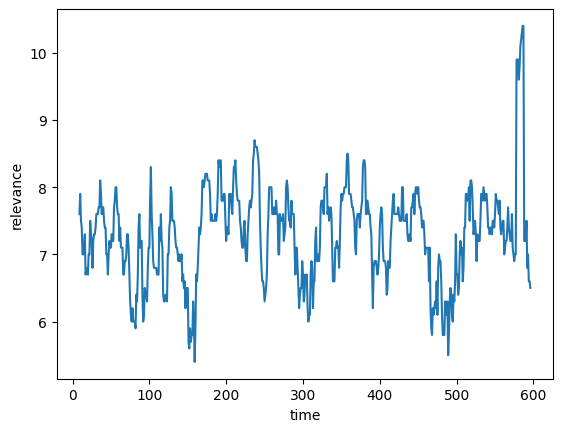

In [75]:
import matplotlib.pyplot as plt
relevance_feedback.index = relevance_feedback.timestamp
plt.plot(relevance_feedback_rolling['relevance_rolling10'], label = 'relevance')
plt.ylabel('relevance')
plt.xlabel('time')

What's next?

1. Replace the openai sentiment classifier with an interpretable one.
2. Use explanations to find root cause of the drop in sentiment.